<a href="https://colab.research.google.com/github/Freddy-94/GeneticAlgorithms/blob/main/GeneticAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alfredo Bernal Luna
### Practice No. 3. Genetic Algorithms.

# Modules to be used in this program:

In [63]:
import numpy as np
from numpy import sqrt, cos, e, pi, exp # for Ackley's function plot
import math
import random
import itertools
from decimal import Decimal
import matplotlib.pyplot as plt  # to plot

# Definition of cost functions:

1. Parabola.

   Let $f : {[-5.12, 5.12]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = \sum_{i=1}^n x_{i}^{2} 
  \end{align}

2. Rosenbrock's function.

   Let $f : {[-2.048, 2.048]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = \sum_{i=1}^n 100 (x_{i}^{2} - x_{i+1})^{2} + (1 - x_{i})^{2}
  \end{align}

3. Ackley's function.

   Let $f : {[-32.768, 32.768]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = -20\mathrm{e}^{-0.2\sqrt{1/n\sum_{i=1}^n x_{i}^{2}}} - \mathrm{e}^{1/n\sum_{i=1}^n \cos {2\pi x_{i}}} + 20 + \mathrm{e}
  \end{align}

In [64]:
def parabola(n, x):
    parabola_value = 0
    for i in range(0, n):
        parabola_value += x[i]**2
    return parabola_value

def rosenbrock(n, x):
    sum = 0
    for i in range(0, n-1):
        sum += ((100 * (x[i]**2 - x[i+1])**2) + (1 - x[i])**2)
    rosenbrock_value = sum
    return rosenbrock_value

def ackley(n, x): 
    gen_cos_avg = 0
    root_mean_square = 0
    for i in range(0, n):
        gen_cos_avg += cos(2*pi*x[i])
        root_mean_square += x[i]**2
    root_mean_square = sqrt((1/n)*(root_mean_square))         
    ackley = -20*exp((-0.2)*(root_mean_square)) - exp(gen_cos_avg) +  20 + e
    return ackley

# Test of the cost functions (dimension = 10):

**1.   Parabola:**

In [65]:
parabola(10, [3.1315, 2.6548, 1.265, 0.264, 0.00156, 2.165, 3.125, 2.568, 1.698, 1.145])

43.765881723599996

**2. Rosenbrock:**

In [66]:
rosenbrock(10, [1.0261, -1.6548, -1.265, 0.264, 0.00156, -2.0165, -0.1235, 2.0326, 1.698, 1.145])

6003.8176985519785

**3. Ackley:**

In [67]:
ackley(10, [31.0261, -31.6548, -21.265, 20.264, 10.00156, -20.0165, -30.1235, 20.0326, 10.698, 10.145])

-45.61924996821731

# Graphs of cost functions, in 3D:

In [68]:
def plot_cost_function_3d(vars_domain, num_points_to_plot, cost_fun):
    """
    Function to plot the graphs of the cost functions, in 3 dimensions. This function might be 
    useful to gain more intuition on the problem at hand
    """
    x1 = np.linspace(vars_domain[0], vars_domain[1], num_points_to_plot)
    x2 = x1
    coord_array_x1, coord_array_x2 = np.meshgrid(x1, x2)
    cost = cost_fun(2, [coord_array_x1, coord_array_x2]) 
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(coord_array_x1, coord_array_x2, cost, rstride = 1, cstride = 1,
                    cmap = 'viridis', edgecolor = 'none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

**1.   Parabola:** 

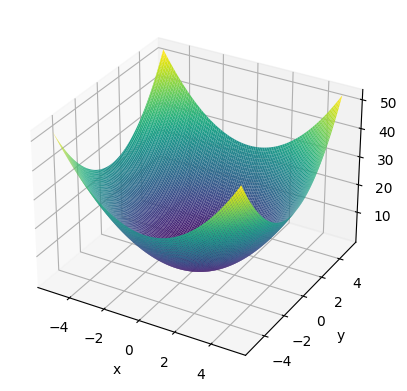

In [69]:
plot_cost_function_3d([-5.12, 5.12], 100, parabola)

**2. Rosenbrock:** 

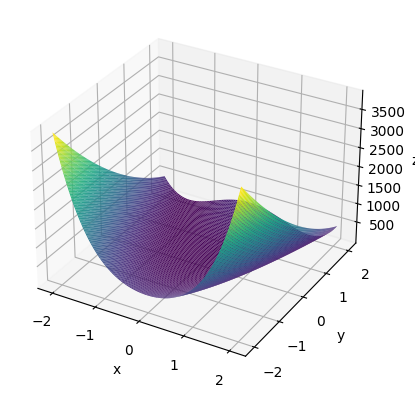

In [70]:
plot_cost_function_3d([-2.048, 2.048], 100, rosenbrock)

**3. Ackley:**

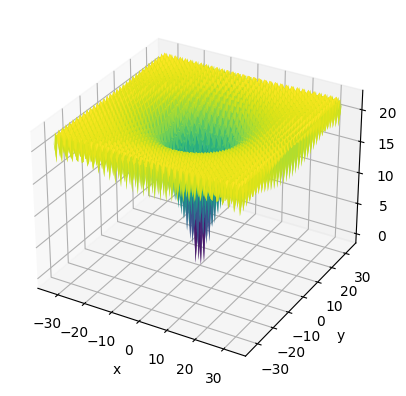

In [71]:
plot_cost_function_3d([-32.768, 32.768], 100, ackley)

# Binary encoding (decoding) of variables of cost functions:

In [72]:
def bit_size_binary(lim_inf, lim_sup, precision):
    """
    Function to obtain the number of bits needed in order to convert from decimal representation
    to binary.
    """
    bit_size = math.log((lim_sup) * (10**precision) - (lim_inf) * (10**precision), 2)
    return math.ceil(bit_size)

def int_to_bin(num, bit_size = 10):
    """
    Function to convert an integer from decimal representation, to a binary representation, given
    the size of the representation we want to show; i.e., given the number of bits we are given.
    """
    bin = ""
    power = 1
    while power <= num//2:
        power *= 2
    while power > 0:
        if num < power:
            bin += "0"
        else:
            bin += "1"
            num -= power
        power //= 2
    return bin.zfill(bit_size)
    
def binary_coding_dict(bit_size, lim_inf, lim_sup, precision):
    """
    This function generates a dictionary of a decimal representation of a value that a 
    variable in the interval might take, along with its corresponding binary representation; i.e.,
    the set of keys of the dictionary consists of the decimal representations of a value that a variable
    in the interval might take, with some given precision, and its values are the corresponding binary
    representations of the decimal representation.

    bit_size is the size of the binary representation that we'll be using to represent each one of its coordinates,
    lim_inf and lim_sup, are the corresponding bounds of the interval that all of our variables can take. This means that 
    our program currently supports only representations for variables having the same domain; i.e., vectors in a domain 
    of the form: [a,b]x[a,b]x...x[a,b].
    Hence, this also means that our program currently works for functions f of the form:
    
    f : [a,b]x[a,b]x...x[a,b] -> R
    """
    lim_inf = Decimal(str(lim_inf))
    lim_sup = Decimal(str(lim_sup))
    dict_binary_coding = {}
    prec = 1 * (10**(-precision))
    prec = Decimal(str(prec))
    count = 0
    """
    while loop to obtain all possible values that a variable can take
    """    
    while  lim_inf <= lim_sup:
        dict_binary_coding[Decimal(lim_inf)] = int_to_bin(count, bit_size)
        count += 1
        lim_inf += prec
    return dict_binary_coding        
            
def binary_encoding(n, x, bin_coding_dict):
    """
    This function recover the binary representation for all of the variables that the 
    input of the cost function might take, and returns it's corresponding vector in 
    binary representation.
    n is the dimension of the vector x in decimal representation, and bin_coding_dict
    is the dictionary obtained in the function binary_coding_dict above.    
    """
    bin_vector = []
    # print(bin_coding_dict)
    for i in range(0, n):
        xi = str(x[i])
        try:
            bin_vector.append(bin_coding_dict[Decimal(xi)])
        except:
            print(f"\nThe function is not defined for the passed number: {x[i]}\n")
            print(f"Please provide an accurate input for coordinate: {i+1}\n")
    return bin_vector

def binary_decoding(bin_vector, bin_coding_dict):
    """
    This function recover the "original" vector in its decimal representation, given we pass its
    binary representation, by querying the dictionary having the decimal and associated binary 
    representations, defined in the function above. Notice this implementation might not be very
    efficient, so that's why we program the below function (so there's no need to build a dict)
    each time we need to decode a binary vector. However, we think it was helpful to see that
    below formula actually works, by taking a peak at this dict
    """
    decoded_vector = []
    for coordinate in bin_vector:
        decimals = [dec for dec, bin in bin_coding_dict.items() if bin == coordinate]
        decoded_vector += decimals   
    return decoded_vector

def bin_decoding_no_dict(bin_vector, lim_sup, precision):
    """
    Binary decoding function for a given bin_vector, and a given precision.
    As per above implementations, we are considering vectors that share the same
    domain, for each one of its variables; i.e., the input vector can take values
    in a domain of the form:  [a, b] x [a, b] x ... x [a, b]
    This is the same as the functions that our current program can handle.
    """
    dec_vect = []
    for bin_repr in bin_vector:
        bin_repr = bin_repr[::-1] # reverse current binary representation
        dec_repr = 0
        for i in range(len(bin_repr)):
            if bin_repr[i] == '1':
                dec_repr += 2**i
        dec_repr = round((dec_repr/(10**precision))-lim_sup, precision+1)
        dec_vect.append(dec_repr)
    return dec_vect
       

# Test of binary decoding function with no dict, for a vector in $\mathbb{R}^{3}$. Notice we need to provide the liminf of the variable each one of the variables. In our particular solution, we are assuming that all of the variables are in the same interval \[a, b].

In [73]:
bin_decoding_no_dict(['00100110101001110', '10100001010110010', '10010000010111011'], 5.12,  4)

[-3.141, 3.141, 2.2715]

# Test of binary coding for vectors in $\mathbb{R}^{3}$, for cost functions defined in its corresponding domain, with a precision of 4 decimal digits. Note that we can give to the function any dimension of $\mathbb{R}^{n}$, along with any precision we wish.

**1.   Parabola's domain:** 

In [74]:
numer_bits_available = bit_size_binary(-5.12, 5.12, 4) # Number of bits that the variables in the parabola function can take, given its definition
bin_dict = binary_coding_dict(numer_bits_available, -5.12, 5.12, 4) # Dictionary storing the variables representation in decimal, with a precision of 4 decimal values
vector_to_encode = [Decimal('-3.1410'), Decimal('3.1410'), Decimal('2.2715')]
vector_in_binary = binary_encoding(3, vector_to_encode, bin_dict) # Input vector in decimal representation, converted to binary vector  
print(vector_in_binary)

['00100110101001110', '10100001010110010', '10010000010111011']


# Decimal-Binary dict to verify that the encoding was done effectively:

In [75]:
print([bin_dict[Decimal('-3.1410')], bin_dict[Decimal('3.1410')], bin_dict[Decimal('2.2715')]])

['00100110101001110', '10100001010110010', '10010000010111011']


**2. Rosenbrock's domain:** 

In [76]:
numer_bits_available = bit_size_binary(-2.048, 2.048, 4) # Number of bits that the variables in the parabola function can take, given its definition
bin_dict = binary_coding_dict(numer_bits_available, -2.048, 2.048, 4) # Dictionary storing the variables representation in decimal, with a precision of 4 decimal values
vector_to_encode = [-1.1410, 0.1410, 2.0215]
vector_in_binary = binary_encoding(3, vector_to_encode, bin_dict) # Input vector in decimal representation, converted to binary vector  
print(vector_in_binary)

['0010001101101110', '0101010110000010', '1001111011110111']


# Decimal-Binary dict to verify that the encoding was done effectively:

In [77]:
print([bin_dict[Decimal('-1.1410')], bin_dict[Decimal('0.1410')], bin_dict[Decimal('2.0215')]])

['0010001101101110', '0101010110000010', '1001111011110111']


**3. Ackley's domain:**

In [78]:
numer_bits_available = bit_size_binary(-32.768, 32.768, 4) # Number of bits that the variables in the parabola function can take, given its definition
bin_dict = binary_coding_dict(numer_bits_available, -32.768, 32.768, 4) # Dictionary storing the variables representation in decimal, with a precision of 4 decimal values
vector_to_encode = [-30.1410, 20.1410, 15.0215]
vector_in_binary = binary_encoding(3, vector_to_encode, bin_dict) # Input vector in decimal representation, converted to binary vector  
print(vector_in_binary)

['00000110011010011110', '10000001001011000010', '01110100101011000111']


# Decimal-Binary dict to verify that the encoding was done effectively:

In [79]:
print([bin_dict[Decimal('-30.1410')], bin_dict[Decimal('20.1410')], bin_dict[Decimal('15.0215')]])

['00000110011010011110', '10000001001011000010', '01110100101011000111']


# Cross-over Classes to implement different types of cross-over operators. Particularly, in this program we're considering only two. Namely, two cross-over and uniform cross-over operators:

In [80]:
class TwoCrossover:
    def __init__(self, parent1, parent2):
        self.parent1 = parent1
        self.parent2 = parent2

    def crossover(self, cut_point1, cut_point2):
        """
        Implementation of the two crossover operator
        """
        children = []
        child1 = self.parent1[:cut_point1] + self.parent2[cut_point1:self.cut_point2] + self.parent1[cut_point2:]
        children.append(child1)
        child2 = self.parent2[:cut_point1] + self.parent1[cut_point1:cut_point2] + self.parent2[cut_point2:]
        children.append(child2)
        return children    

class UniformCrossover:
    def __init__(self, parent1, parent2):
        self.parent1 = parent1
        self.parent2 = parent2

    def crossover(self, prob_vect, cross_perc):
        """
        Implementation of the uniform crossover operator
        prob_vect is a probability vector generated by np.random.rand(n),
        where n is the length of the parents
        """
        for i in range(len(prob_vect)):
            # print(prob_vect[i]) to validate that the unifor crossover operation is implemented correctly
            if prob_vect[i] < cross_perc:
                self.parent1[i], self.parent2[i] = self.parent2[i], self.parent1[i]
        return [self.parent1, self.parent2]

# Genetic algorithm implementation:

In [81]:
def initial_population(population_size, vars_domain, dim, precision): 
    """
    This function creates the initial random population to start the algorithm.
    population_size must be an even number, in order to create the tournament. See below 
    bin_tournament function.
    """    
    population = []
    for i in range(0, population_size):
        individual = []    
        for i in range(0, dim):
            individual.append(round(random.uniform(vars_domain[0], vars_domain[1]), precision))
        population.append(individual)
    return population

def table_pop_fitnesss(population, cost_fun):
    """
    This function provides a list of lists, showing the initial population, along its 
    corresponding aptitudes (their corresponding values that are obtained after evaluating
    the given cost function)
    """
    table = []
    for individual in population:
        table += [[individual, cost_fun(len(individual), individual)]]
    return table

def stoch_rem_par_sel(table_pop_fitness):
    """
    Stochastic reminder parents selection without replacement implementation
    """
    total_fitness = 0
    exp_val_vector = []
    for i in range(len(table_pop_fitness)):
        total_fitness += table_pop_fitness[i][1]
        exp_val_vector.append(table_pop_fitness[i][1])
    avg_fitness = total_fitness/len(table_pop_fitness)
    exp_val_vector = np.array(exp_val_vector)
    exp_val_vector = exp_val_vector/avg_fitness
    exp_val_vector = exp_val_vector.tolist()
    dec_exp_val_vector = []
    parents = []
    for exp_val in exp_val_vector:
        exp_val_dec = round(exp_val % 1, 2)
        dec_exp_val_vector.append(exp_val_dec)
        exp_val_int = int(exp_val)
        if exp_val_int > 0:
            parents += [table_pop_fitness[exp_val_vector.index(exp_val)]] * exp_val_int    
    for dec_exp_val in dec_exp_val_vector:
        flip = random.uniform(0,1)
        if flip < dec_exp_val: # and table_pop_fitness[dec_exp_val_vector.index(dec_exp_val)] not in parents: Notice we are allowing to repeat parents
            parents.append(table_pop_fitness[dec_exp_val_vector.index(dec_exp_val)])            
    return parents

def bin_tournament_survivors(size_matches, table_pop_fitness):
    """
    This function starts the binary tournament between individuals of a population,
    and returns the selected survivors. Notice that the size_matches can be changed with another 
    value different than 2. 
    """
    if len(table_pop_fitness) % 2 != 0: # Validation just for binary tournament
        table_pop_fitness = sorted(table_pop_fitness, key = lambda x : float(x[1])) # order table in terms of values of cost_fun
        table_pop_fitness = table_pop_fitness.remove(table_pop_fitness[0])     # This new population removes the least suitable individual; i.e., the individual "least" such                                                                           
    for i in range(size_matches):                                              # that cost_fun(least) < cost_fun(individual), for all individual in ordered_population   
        random.shuffle(table_pop_fitness)
        print(table_pop_fitness)
        survivors = []
        for j in range(0, len(table_pop_fitness), 2):
            if table_pop_fitness[j][1] > table_pop_fitness[j+1][1]: #and table_pop_fitness[j][1] not in survivors:                
                survivors.append(table_pop_fitness[j])
            elif table_pop_fitness[j+1][1] > table_pop_fitness[j][1]: #and table_pop_fitness[j+1][1] not in survivors:
                survivors.append(table_pop_fitness[j+1])
    return survivors 

def mutation(chromosome, delta, mut_perc):
    """
    Implementation of the mutation operator 
    """
    new_chrom = []
    for gen in chromosome:
        if random.uniform(0,1) <= mut_perc:
            if random.uniform(0,1) <= 0.5:
                gen += delta
            else:
                gen -= delta
        new_chrom.append(gen)
    return new_chrom  

def genetic():
    print(initial_population(6, [-5.12, 5.12], 4, 4))
    return   

In [82]:
genetic()

[[-1.8622, -1.6222, 3.0157, 3.9965], [3.4186, -1.6061, 1.5747, 1.6547], [1.7749, 1.611, 4.2095, 0.1431], [-4.1, -1.8277, 0.6417, -4.9909], [-2.6281, 0.0858, -3.4283, 3.3485], [-3.5318, -3.8409, 2.5293, -3.944]]
